In [ ]:
!mkdir -p images

In [ ]:
! cp -r /content/drive/MyDrive/CatsVsDogs.zip /content/images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q /content/images/CatsVsDogs.zip -d /content/images

In [ ]:
!mkdir images/train
!mkdir images/test
!mkdir images/train/Cat
!mkdir images/train/Dog
!mkdir images/test/Cat
!mkdir images/test/Dog

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

images = []
classes = []

#pega o nome de todas as images da classe Cat e insere na lista atribuindo o rotulo 0
for filename in os.listdir('/content/images/Cat'):
    images.append(str(filename))
    classes.append('Cat')

#pega o nome de todas as images da classe Dog e insere na lista atribuindo o rotulo 1
for filename in os.listdir('/content/images/Dog'):
    images.append(str(filename))
    classes.append('Dog')

X_train, X_test, y_train, y_test = train_test_split(np.array(images), np.array(classes), test_size=0.25, random_state=42, shuffle=True)

#percorre a lista de imagens de treino e copia para o diretorio de treino conforme a classe
for i in range(X_train.shape[0]):
  shutil.copyfile('/content/images/'+y_train[i]+'/'+X_train[i],'/content/images/train/'+y_train[i]+'/'+X_train[i])

#percorre a lista de imagens de teste e copia para o diretorio de teste conforme a classe
for i in range(X_test.shape[0]):
  shutil.copyfile('/content/images/'+y_test[i]+'/'+X_test[i],'/content/images/test/'+y_test[i]+'/'+X_test[i])

**Implementação do Modelo VGG16 pré-treinado**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

model = Sequential()
model.add(VGG16(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(2,activation='softmax'))

#faz com que as camadas da rede VGG16 sejam congeladas(não serão treinadas)
for layer in model.layers[0].layers:
  layer.treinable = False

model.summary()
model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics= ['accuracy'])

58900480/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


Found 639 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}
Found 112 images belonging to 2 classes.
Found 251 images belonging to 2 classes.
Epoch 1/50
20/20 [==============================] - 78s 2s/step - loss: 4.1959 - accuracy: 0.5775 - val_loss: 0.7526 - val_accuracy: 0.6161
Epoch 2/50
20/20 [==============================] - 17s 851ms/step - loss: 0.6835 - accuracy: 0.5931 - val_loss: 0.5993 - val_accuracy: 0.6696
Epoch 3/50
20/20 [==============================] - 17s 847ms/step - loss: 0.6110 - accuracy: 0.6808 - val_loss: 0.5709 - val_accuracy: 0.6964
Epoch 4/50
20/20 [==============================] - 17s 849ms/step - loss: 0.6172 - accuracy: 0.6745 - val_loss: 0.5815 - val_accuracy: 0.6964
Epoch 5/50
20/20 [==============================] - 17s 847ms/step - loss: 0.6110 - accuracy: 0.6729 - val_loss: 0.5844 - val_accuracy: 0.6161
Epoch 6/50
20/20 [==============================] - 17s 850ms/step - loss: 0.6127 - accuracy: 0.6854 - val_loss: 0.5699 - val_accuracy: 0.7143
E

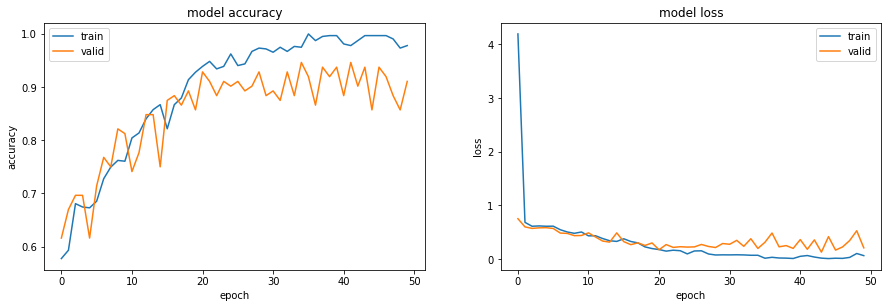

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 50

#Cria uma ImageDataGenerator que será utilizado para fazer a leitura das imagens de treino
train_data_generator =  ImageDataGenerator(validation_split = 0.15, preprocessing_function = preprocess_input,
                                          rotation_range=15,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

#Faz a leitura das imagens de treino
train_data = train_data_generator.flow_from_directory('/content/images/train', target_size = (IMAGE_SIZE,IMAGE_SIZE), subset='training')

print(train_data.class_indices)

#Faz a leitura das imagens de validação - subconjunto do conjunto de treino
validation_data = train_data_generator.flow_from_directory('/content/images/train', target_size = (IMAGE_SIZE,IMAGE_SIZE), subset='validation')

#Cria uma ImageDataGenerator que será utilizado para fazer a leitura das imagens de teste
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
#Faz a leitura das imagens de teset
test_data = test_data_generator.flow_from_directory('/content/images/test', target_size = (IMAGE_SIZE,IMAGE_SIZE))

fit_history = model.fit(
  train_data,
  epochs = EPOCHS,
  validation_data = validation_data 
)

evaluated =  model.evaluate(test_data)
print("Acurácia: %f" %(evaluated[1]))
print("Loss: %f" %(evaluated[0]))

plt.figure(1, figsize = (15,10)) 
      
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
